In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from sklearn.linear_model import LogisticRegression

# For now, I just ran the code for one game; but we will need to input a data frame with all games and for seasons 2018-2019-2020

In [6]:
%run "/Users/raphaelbourque/Desktop/data_science_class/hockey-primer-1-master-2/notebook/2_date_retrival.ipynb"

In [7]:
df = get_goal_shots_data_by_game_id(game_id=2017020001)

In [8]:
def plot_counts_by_shot_type_and_goal_proportion(df: pd.DataFrame) -> plt.figure:
    """
    This functions summarizes the data as a table of counts of events by type and secondary type, 
    and then produces a stacked barplot with annotations for percentage of goals over all shots for each shot type
    @param df: tidy data frame
    @return: seaborn figure
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    df['count'] = 1
    total_counts = df.groupby(['event_secondary_type','event']).count().reset_index()
    total_counts = total_counts.pivot(index='event_secondary_type', columns='event', values='count')
    total_counts.plot(kind='bar', stacked=True, color=['#a3acff', '#f9bc86'], ax=ax)

    total_counts['Proportion'] = (total_counts['Goal']/(total_counts['Shot'] + total_counts['Goal']))*100
    ax.set(title='Goals and missed shots, by shot type', xlabel='Shot type', ylabel='Count')

    patches = ax.patches[:(len(ax.patches)//2)]
    for i, p in enumerate(patches):
        h, w, x = p.get_height(), p.get_width(), p.get_x()
        xy = (x + w / 2., h + 0.5)
        text = total_counts['Proportion'][i]
        if np.isnan(text):
            text = 0
        text = f'{text:0.1f}%'
        ax.annotate(text=text, xy=xy, ha='center', va='center')
    
    plt.show()
    return plt.gcf()

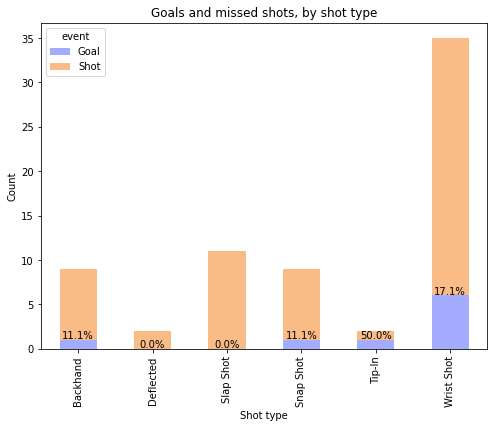

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [9]:
plot_counts_by_shot_type_and_goal_proportion(df)

In [10]:
def distance(coordinates: tuple) -> float:
    """
    This functions computes the distance at which a shot was taken, i.e. the distance between the coordinates and the goal. 
    ### For now, it assumes that shots are taken from in front of the center line, but we will need to correct this ###
    @param coordinates: coordinates on the ice
    @return: distance
    """
    x, y = coordinates 
    x = 89 - abs(x) 
    y = y
    distance = math.hypot(x,y)
    return distance

In [11]:
def distance_goal_relationship(df: pd.DataFrame) -> plt.figure:
    """
    This functions plots density of distance as a function of goal or other shot, 
    and then computes and plots a logistic regression between the distance a shot was taken and the outcome (goal)
    @param df: tidy data frame
    @return: plot
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    df['distance'] = df['coordinates'].apply(distance)
    sns.kdeplot(data=df, x="distance", hue="event_type_id", bw_adjust=.7, ax=ax[0]) # adjust kernel size here
    
    df['goal'] = np.where(df['event_type_id']== 'GOAL', 1, 0)
    x = df['distance']
    y = df['goal']

    mod = LogisticRegression(random_state=0).fit(pd.DataFrame(x), y)
    slope = mod.coef_[0][0]
    intercept = mod.intercept_[0]

    sns.regplot(x=x, y=y, data=df, logistic=True, ci=None, scatter_kws={'color': 'black'}, line_kws={'color': 'red'}, ax=ax[1])
    ax[0].set(title="Density plot of the distance for goals and missed shots")
    ax[1].set(title="Probability of a goal as a function of distance", xlabel='distance', ylabel='Probability of a goal')
    annotation = "logit(y)={:.2f}x+{:.2f}".format(slope,intercept)
    plt.text(50, 0.6, annotation, size='large', color='red')
    
    plt.show()
    return plt.gcf()

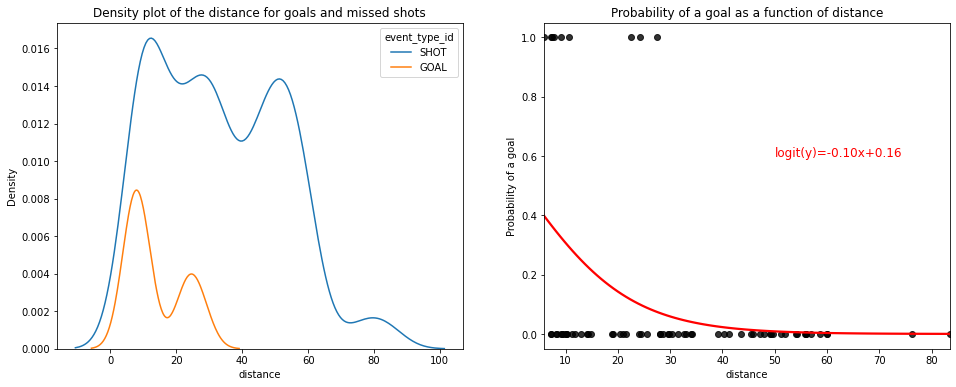

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [12]:
distance_goal_relationship(df)

In [13]:
def distance_goal_relationship(df: pd.DataFrame) -> plt.figure:
    """
    This functions computes the percentage of goals over all shots, for each bin of distance and for each type of shot. 
    @param df: tidy data frame
    @return: distance
    """
    
    df['distance'] = df['coordinates'].apply(distance)
    df['distance_category'] = pd.cut(df.distance,bins=[0,5,10,20,30,40,50,60,80,90],labels=['<5','5-10','10-20','20-30','30-40','40-50','50-60','60-80','80-90'])
    df['count'] = 1

    total_counts = df.groupby(['event_secondary_type','distance_category']).count().reset_index()
    total_counts = total_counts.pivot(index='distance_category', columns='event_secondary_type', values='count')

    goal_counts = df[df.event == 'Goal']
    goal_counts = goal_counts.groupby(['event_secondary_type','distance_category']).count().reset_index()
    goal_counts = goal_counts.pivot(index='distance_category', columns='event_secondary_type', values='count')

    goal_percent = (goal_counts/total_counts)*100

    fig, ax = plt.subplots(figsize=(8, 6))
    goal_percent.plot(kind='line', stacked=False, ax=ax, marker='o')
    ax.set(title='Proportion of goals by distance and shot type', ylabel="Proportion of goals over all shots (%)")
    plt.show()
    return plt.gcf()

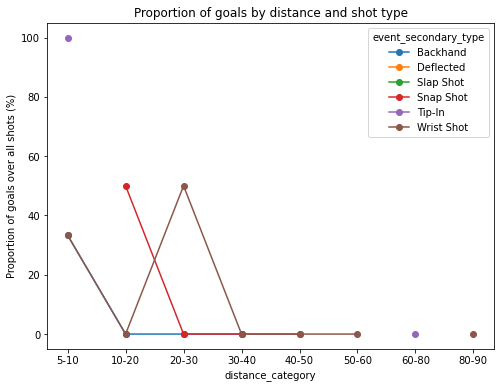

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [14]:
distance_goal_relationship(df)